In [41]:
# helpful pre-reads:
# https://www.kaggle.com/veleon/spam-classification
# https://stackabuse.com/text-classification-with-python-and-scikit-learn
# https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

# Steps taken below:
# Convert email into feature vector
# Create Test & Training Set
# Add Hyperparameters to:
# - Strip email headers
# - Convert to lowercase
# - Remove punctuation
# - Replace urls with "URL"
# - Replace numbers with "NUMBER"
# - Perform Stemming (trim word endings with library)

import os
import re
import email
import email.policy
from typing import Any

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import urlextract

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns

os.listdir('data')

['spam', '.DS_Store', 'enron1', 'easy_ham', 'gmail_spam_examples']

In [2]:
ham_filenames = [name for name in sorted(os.listdir('data/easy_ham')) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir('data/spam')) if len(name) > 20]

print('Amount of ham files:', len(ham_filenames))
print('Amount of spam files:', len(spam_filenames))    
print('Spam to Ham Ratio:',len(spam_filenames)/len(ham_filenames))

Amount of ham files: 2500
Amount of spam files: 500
Spam to Ham Ratio: 0.2


In [3]:
def load_email(is_spam, filename):
    directory = "data/spam" if is_spam else "data/easy_ham"
    with open(os.path.join(directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)
    
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]
    
    
testEmail = ham_emails[0]

print('Header Field Names:',testEmail.keys())
print('\n\n')
print('Message Field Values:',testEmail.values())
print('\n\n')
print('Message Content:',testEmail.get_content())

Header Field Names: ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Cc', 'Subject', 'In-Reply-To', 'References', 'MIME-Version', 'Content-Type', 'Message-Id', 'X-Loop', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']



Message Field Values: ['<exmh-workers-admin@spamassassin.taint.org>', 'zzzz@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36\tfor <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)', 'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)', 'from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by    dogma.slashnul

In [4]:
testEmail['Subject']

'Re: New Sequences Window'

In [5]:
print(spam_emails[6].get_content())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40




In [6]:
from collections import Counter

def get_email_structure(email):    
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

ham_structure = structures_counter(ham_emails)
spam_structure = structures_counter(spam_emails)

In [7]:
ham_structure.most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [8]:
spam_structure.most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [9]:
for email in spam_emails:
    if get_email_structure(email) == 'text/html':
        testEmail = email
        break

print(testEmail.get_content())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

In [10]:
def html_to_plain(email):
    try:
        soup = BeautifulSoup(email.get_content(), 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"

print(html_to_plain(testEmail))


Save up to 70% on Life Insurance.
Why Spend More Than You Have To?Life Quote Savings
Ensuring your 
      family's financial security is very important. Life Quote Savings makes 
      buying life insurance simple and affordable. We Provide FREE Access to The 
      Very Best Companies and The Lowest Rates.Life Quote Savings is FAST, EASY and 
            SAVES you money! Let us help you get started with the best values in 
            the country on new coverage. You can SAVE hundreds or even thousands 
            of dollars by requesting a FREE quote from Lifequote Savings. Our 
            service will take you less than 5 minutes to complete. Shop and 
            compare. SAVE up to 70% on all types of Life insurance! Click Here For Your 
            Free Quote!Protecting your family is the best investment you'll ever 
          make!
If you are in receipt of this email 
      in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you 
      resi

In [11]:
def email_to_plain(email):
    struct = get_email_structure(email)
    for part in email.walk():
        partContentType = part.get_content_type()
        if partContentType not in ['text/plain','text/html']:
            continue
        try:
            partContent = part.get_content()
        except: # in case of encoding issues
            partContent = str(part.get_payload())
        if partContentType == 'text/plain':
            return partContent
        else:
            return html_to_plain(part)

print(email_to_plain(ham_emails[42]))
print('-----')
print(email_to_plain(spam_emails[42]))

< >
> I downloaded a driver from the nVidia website and installed it using RPM.
> Then I ran Sax2 (as was recommended in some postings I found on the net),
but
> it still doesn't feature my video card in the available list. What next?


hmmm.

Peter.

Open a terminal and as root type
lsmod
you want to find a module called
NVdriver.

If it isn't loaded then load it.
#insmod NVdriver.o
Oh and ensure you have this module loaded on boot.... else when you reboot
you might be in for a nasty surprise.

Once the kernel module is loaded

#vim /etc/X11/XF86Config

in the section marked
Driver I have "NeoMagic"
you need to have
Driver "nvidia"

Here is part of my XF86Config

Also note that using the card you are using you 'should' be able to safely
use the FbBpp 32 option .

Section "Module"
 Load  "extmod"
 Load  "xie"
 Load  "pex5"
 Load  "glx"
 SubSection "dri"    #You don't need to load this Peter.
  Option     "Mode" "666"
 EndSubSection
 Load  "dbe"
 Load  "record"
 Load  "xtrap"
 Load  "sp

In [40]:
snowball_stemmer = SnowballStemmer('english')
for word in ("Working", "Work", "Works", "Worked", "Cheerful", "."):
    print(word, "=>", snowball_stemmer.stem(word))

Working => work
Work => work
Works => work
Worked => work
Cheerful => cheer
. => .


In [13]:
url_extractor = urlextract.URLExtract()
print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pqs"))

['github.com', 'https://youtu.be/7Pqs']


In [42]:

# - Strip email headers
# - Convert to lowercase
# - Remove punctuation
# - Replace urls with "URL"
# - Replace numbers with "NUMBER"
# - Perform Stemming (trim word endings with library)
class EmailToWords(BaseEstimator, TransformerMixin):
    def __init__(self, stripHeaders=True, lowercaseConversion = True, punctuationRemoval = True, 
                 urlReplacement = True, numberReplacement = True, stemming = True):
        self.stripHeaders = stripHeaders
        self.lowercaseConversion = lowercaseConversion
        self.punctuationRemoval = punctuationRemoval
        self.urlReplacement = urlReplacement
        self.urlExtractor = urlextract.URLExtract()
        self.numberReplacement = numberReplacement
        self.stemming = stemming
        self.stemmer = SnowballStemmer('english') # AKA porter2 stemmer, better than porter stemmer
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_to_words = []
        for email in X:
            text = email_to_plain(email)
            if text is None:
                text = 'empty'
            if self.lowercaseConversion:
                text = text.lower()
                
            if self.urlReplacement:
                urls = self.urlExtractor.find_urls(text)
                for url in urls:
                   text = text.replace(url, 'URL')   
                    
            if self.punctuationRemoval:
                text = text.replace('.','')
                text = text.replace(',','')
                text = text.replace('!','')
                text = text.replace('?','')
                
            word_counts = Counter(text.split())
            if self.stemming:
                stemmed_word_count = Counter()
                for word, count in word_counts.items():
                    stemmed_word = self.stemmer.stem(word)
                    stemmed_word_count[stemmed_word] += count
                word_counts = stemmed_word_count
            X_to_words.append(word_counts)
        return np.array(X_to_words)
    
class EmailToText(BaseEstimator, TransformerMixin):
    def __init__(self, lowercaseConversion = True, punctuationRemoval = True, 
                 urlReplacement = True, numberReplacement = True, stemming = True):
        self.lowercaseConversion = lowercaseConversion
        self.punctuationRemoval = punctuationRemoval
        self.urlReplacement = urlReplacement
        self.urlExtractor = urlextract.URLExtract()
        self.numberReplacement = numberReplacement
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_to_words = []
        for email in X:
            text = email_to_plain(email)
            
            if text is None:
                text = 'empty'
            if self.lowercaseConversion:
                text = text.lower()
                
            if self.urlReplacement:
                urls = self.urlExtractor.find_urls(text)
                for url in urls:
                   text = text.replace(url, 'URL')   
            
            # apparently removing numbers helped
            if self.numberReplacement:
                text = re.sub('\d', '%d', text)
                    
            if self.punctuationRemoval:
                text = text.replace('.','')
                text = text.replace(',','')
                text = text.replace('!','')
                text = text.replace('?','')
                
            if self.stemming:
                words = text.split(' ')
                
                stemmed_words = []
                for word in words:
                    stemmed_words.append(snowball_stemmer.stem(word))
                
                text = ' '.join(stemmed_words)
            
            X_to_words.append(text)
        return np.array(X_to_words)

In [15]:
X_few = ham_emails[:3]
Xwordcounts = EmailToWords().fit_transform(X_few)
Xwordcounts

array([Counter({'the': 15, 'pick': 9, '-lbrace': 6, 'of': 5, '-rbrace': 5, 'i': 4, 'is': 4, '-list': 4, 'this': 3, '+inbox': 3, '-subject': 3, 'ftp': 3, '-sequenc': 3, '18:19:04': 3, 'command': 3, 'delta$': 3, 'that': 3, 'from': 3, 'error': 2, '18:19:03': 2, '4852-4852': 2, 'mercuri': 2, '1': 2, 'hit': 2, 'come': 2, 'version': 2, 'use': 2, 'on': 2, 'url': 2, 'and': 2, 'one': 2, 'date:': 1, 'wed': 1, '21': 1, 'aug': 1, '2002': 1, '10:54:46': 1, '-0500': 1, 'from:': 1, 'chris': 1, 'garrigu': 1, '<cwg-dated-103037728706fa6d@deepeddycom>': 1, 'message-id:': 1, '<10299452874797tmda@deepeddyvirciocom>': 1, '|': 1, "can't": 1, 'reproduc': 1, 'for': 1, 'me': 1, 'it': 1, 'veri': 1, 'repeat': 1, '(like': 1, 'everi': 1, 'time': 1, 'without': 1, 'fail)': 1, 'debug': 1, 'log': 1, 'happen': 1, 'pick_it': 1, '{exec': 1, '-rbrace}': 1, '{4852-4852': 1, 'mercury}': 1, 'exec': 1, 'ftoc_pickmsg': 1, '{{1': 1, 'hit}}': 1, 'mark': 1, 'tkerror:': 1, 'syntax': 1, 'in': 1, 'express': 1, '"int': 1, 'note': 1, 

In [16]:
X_few_text = EmailToText().fit_transform(X_few)
vocab_transformer = CountVectorizer()
X_few_vectors = vocab_transformer.fit_transform(X_few_text)
X_few_vectors

<3x296 sparse matrix of type '<class 'numpy.int64'>'
	with 344 stored elements in Compressed Sparse Row format>

In [37]:
# 1x296
X_few_vectors[0].todense()

matrix([[ 1,  1,  0,  1,  0,  0,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,
          1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
          1,  0,  1,  1,  0,  0,  1,  0,  0,  1,  2,  3,  0,  1,  0,  1,
          0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  3,  0,  0,  1,  1,
          0,  1,  0,  0,  0,  0,  0,  2,  0,  1,  2,  2,  1,  0,  0,  1,
          1,  0,  0,  0,  0,  1,  0,  1,  0,  0,  4,  0,  0,  1,  3,  0,
          1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,
          0,  0,  0,  0,  3,  1,  0,  0,  1,  1,  0,  1,  0,  1,  3,  1,
          0,  0,  4,  1,  1,  0,  0,  0,  0,  1,  0,  0,  6,  1,  0,  1,
          5,  0,  1,  0,  1,  1,  0,  1,  1,  0,  1,  3,  1,  2,  1,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  2,  0,  0,  1,
          0,  0,  1,  5,  0,  0,  0,  2,  2,  0,  0,  0,  0,  0,  0,  1,
          0,  0,  9,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,
          6,  1,  0,  1,  1,  1,  0,  1,  1,  0,  0

In [35]:
vocab_transformer.vocabulary_

{'date': 52,
 'wed': 282,
 'aug': 19,
 'from': 90,
 'chris': 38,
 'garrigues': 96,
 'cwg': 51,
 'dated': 53,
 'dfa': 62,
 'dd': 55,
 'deepeddycom': 57,
 'message': 156,
 'id': 121,
 'dtmda': 65,
 'deepeddyvirciocom': 58,
 'can': 35,
 'reproduce': 216,
 'this': 259,
 'error': 71,
 'for': 85,
 'me': 154,
 'it': 132,
 'is': 130,
 'very': 277,
 'repeatable': 213,
 'like': 141,
 'every': 73,
 'time': 263,
 'without': 290,
 'fail': 80,
 'the': 255,
 'debug': 56,
 'log': 148,
 'of': 179,
 'pick': 194,
 'happening': 107,
 'pick_it': 195,
 'exec': 74,
 'inbox': 126,
 'list': 144,
 'lbrace': 140,
 'subject': 244,
 'ftp': 94,
 'rbrace': 208,
 'sequence': 235,
 'mercury': 155,
 'ftoc_pickmsgs': 93,
 'hit': 116,
 'marking': 152,
 'hits': 117,
 'tkerror': 264,
 'syntax': 247,
 'in': 125,
 'expression': 79,
 'int': 127,
 'note': 175,
 'if': 123,
 'run': 220,
 'command': 43,
 'by': 34,
 'hand': 106,
 'delta': 59,
 'that': 254,
 'where': 285,
 'comes': 42,
 'obviously': 178,
 'version': 276,
 'nmh': 17

In [18]:
X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# https://stackoverflow.com/questions/36182502/add-stemming-support-to-countvectorizer-sklearn
stemmer = SnowballStemmer('english')

analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# omit analyzer=stemmed_words from below because can't stem and use stopwords/ngrams at the same time
stem_vectorizer = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))
print(stem_vectorizer.fit_transform([email_to_plain(email) for email in X_few]))
print(stem_vectorizer.get_feature_names())

  (0, 158)	1
  (0, 635)	1
  (0, 32)	1
  (0, 85)	1
  (0, 28)	2
  (0, 11)	1
  (0, 47)	1
  (0, 40)	1
  (0, 7)	1
  (0, 115)	1
  (0, 240)	1
  (0, 156)	1
  (0, 160)	1
  (0, 15)	1
  (0, 9)	1
  (0, 166)	2
  (0, 125)	4
  (0, 367)	1
  (0, 290)	1
  (0, 13)	1
  (0, 42)	1
  (0, 602)	1
  (0, 627)	1
  (0, 499)	1
  (0, 191)	2
  :	:
  (2, 109)	1
  (2, 459)	1
  (2, 195)	1
  (2, 180)	1
  (2, 563)	1
  (2, 400)	1
  (2, 383)	1
  (2, 424)	1
  (2, 442)	1
  (2, 280)	1
  (2, 90)	1
  (2, 269)	1
  (2, 403)	1
  (2, 384)	1
  (2, 460)	1
  (2, 469)	1
  (2, 550)	1
  (2, 519)	1
  (2, 394)	1
  (2, 76)	1
  (2, 82)	1
  (2, 552)	1
  (2, 244)	1
  (2, 530)	1
  (2, 343)	1
['03', '03 exec', '03 pick_it', '04', '04 ftoc_pickmsgs', '04 marking', '04 tkerror', '0500', '0500 chris', '06fa6d', '06fa6d deepeddy', '10', '10 54', '1029945287', '1029945287 4797', '1030377287', '1030377287 06fa6d', '14', '14 55', '17', '17 14', '170', '170 ft', '18', '18 19', '19', '19 03', '19 04', '2002', '2002 10', '2002 40', '2002 relevant', '21', '

In [20]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [21]:
email_pipeline = Pipeline([
    ("Email to Words", EmailToText()), # omit analyzer=stemmed_words from below
    ("Words to Count Vector", CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))),
])

In [22]:
X_augmented_train = email_pipeline.fit_transform(X_train)

In [23]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = model_selection.cross_val_score(log_clf, X_augmented_train, y_train, cv=3)
score.mean()

0.985

In [24]:
X_augmented_test = email_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_augmented_train, y_train)

y_pred = log_clf.predict(X_augmented_test)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 100.00%
Recall: 91.58%


In [43]:
email_pipeline2 = Pipeline([
    ("Email to Words", EmailToText(stemming=True, numberReplacement=True)),
    ("Words to TF-IDF Vector", TfidfVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))),
])

X_augmented_train2 = email_pipeline2.fit_transform(X_train)
X_augmented_test2 = email_pipeline2.transform(X_test)

log_clf = LogisticRegression(solver="liblinear", random_state=42)
log_clf.fit(X_augmented_train2, y_train)

y_pred2 = log_clf.predict(X_augmented_test2)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred2)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred2)))

Precision: 100.00%
Recall: 70.53%


In [25]:
def eval_model(name: str, model: Any, X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['malignant spam', 'benign ham']

    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)

    if name == 'GNB':
        X_train = X_train.copy().todense()
        X_test = X_test.copy().todense()

    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    res = pd.DataFrame(cv_results)
    res['model'] = name
    return res
        


In [26]:
result_dfs = []

# Logistic Regression: basic linear classifier (good to baseline)
# Random Forest: ensemble bagging classifier
# K-Nearest Neighbors: instance based classifier
# Support Vector Machines: maximum margin classifier
# Gaussian Naive Bayes: probabilistic classifier
# XGBoost: ensemble (extreme!) boosting classifier
models = [
    ('LogReg', LogisticRegression()), 
    ('RF', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()), 
    ('GNB', GaussianNB()),
    ('XGB', XGBClassifier())
]

for name, model in models:
    result_dfs.append(eval_model(name, model, X_augmented_train, y_train, X_augmented_test, y_test))

final = pd.concat(result_dfs, ignore_index=True)
final

LogReg
                precision    recall  f1-score   support

malignant spam       0.98      1.00      0.99       505
    benign ham       1.00      0.92      0.96        95

      accuracy                           0.99       600
     macro avg       0.99      0.96      0.97       600
  weighted avg       0.99      0.99      0.99       600

RF
                precision    recall  f1-score   support

malignant spam       0.98      0.98      0.98       505
    benign ham       0.91      0.91      0.91        95

      accuracy                           0.97       600
     macro avg       0.94      0.94      0.94       600
  weighted avg       0.97      0.97      0.97       600

KNN
                precision    recall  f1-score   support

malignant spam       0.97      0.71      0.82       505
    benign ham       0.37      0.88      0.52        95

      accuracy                           0.74       600
     macro avg       0.67      0.80      0.67       600
  weighted avg       0.87 

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,1.585125,0.006222,0.983333,0.983663,0.983333,0.983000,0.987359,LogReg
1,1.365936,0.005019,0.977083,0.977305,0.977083,0.976580,0.987723,LogReg
2,1.574371,0.005684,0.989583,0.989564,0.989583,0.989503,0.998062,LogReg
3,1.610519,0.005525,0.989583,0.989562,0.989583,0.989501,0.999872,LogReg
4,1.626556,0.005635,0.987500,0.987488,0.987500,0.987364,0.998292,LogReg
5,5.386617,0.158358,0.956250,0.955533,0.956250,0.955716,0.992680,RF
6,5.710619,0.141853,0.962500,0.962410,0.962500,0.961375,0.991427,RF
7,5.378554,0.131414,0.970833,0.970848,0.970833,0.970041,0.996516,RF
8,5.832534,0.132624,0.966667,0.967263,0.966667,0.965309,0.994020,RF
9,5.789411,0.147960,0.966667,0.966187,0.966667,0.965917,0.982614,RF


In [27]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

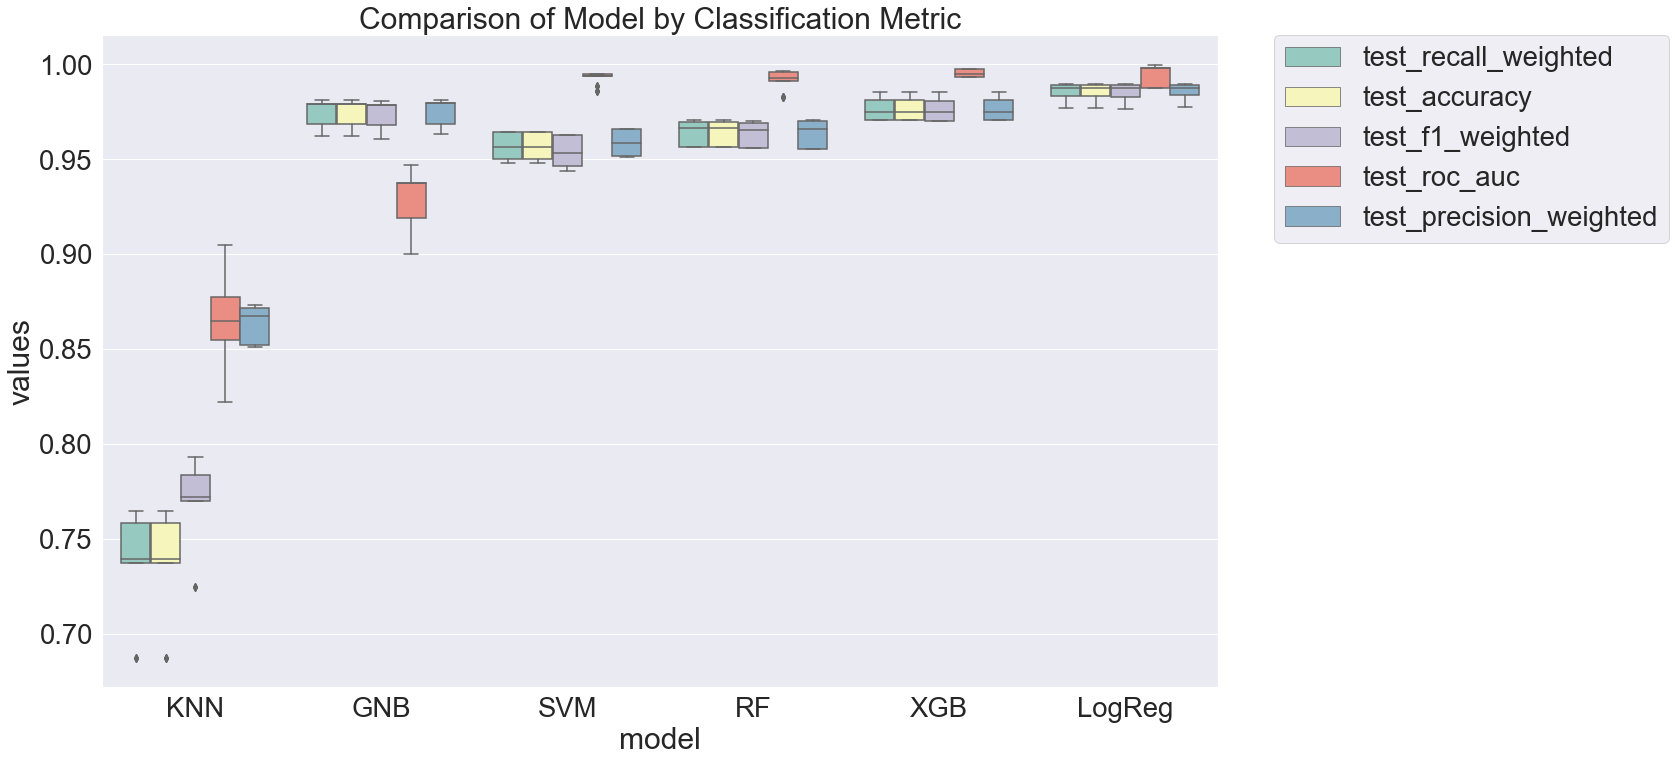

In [28]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

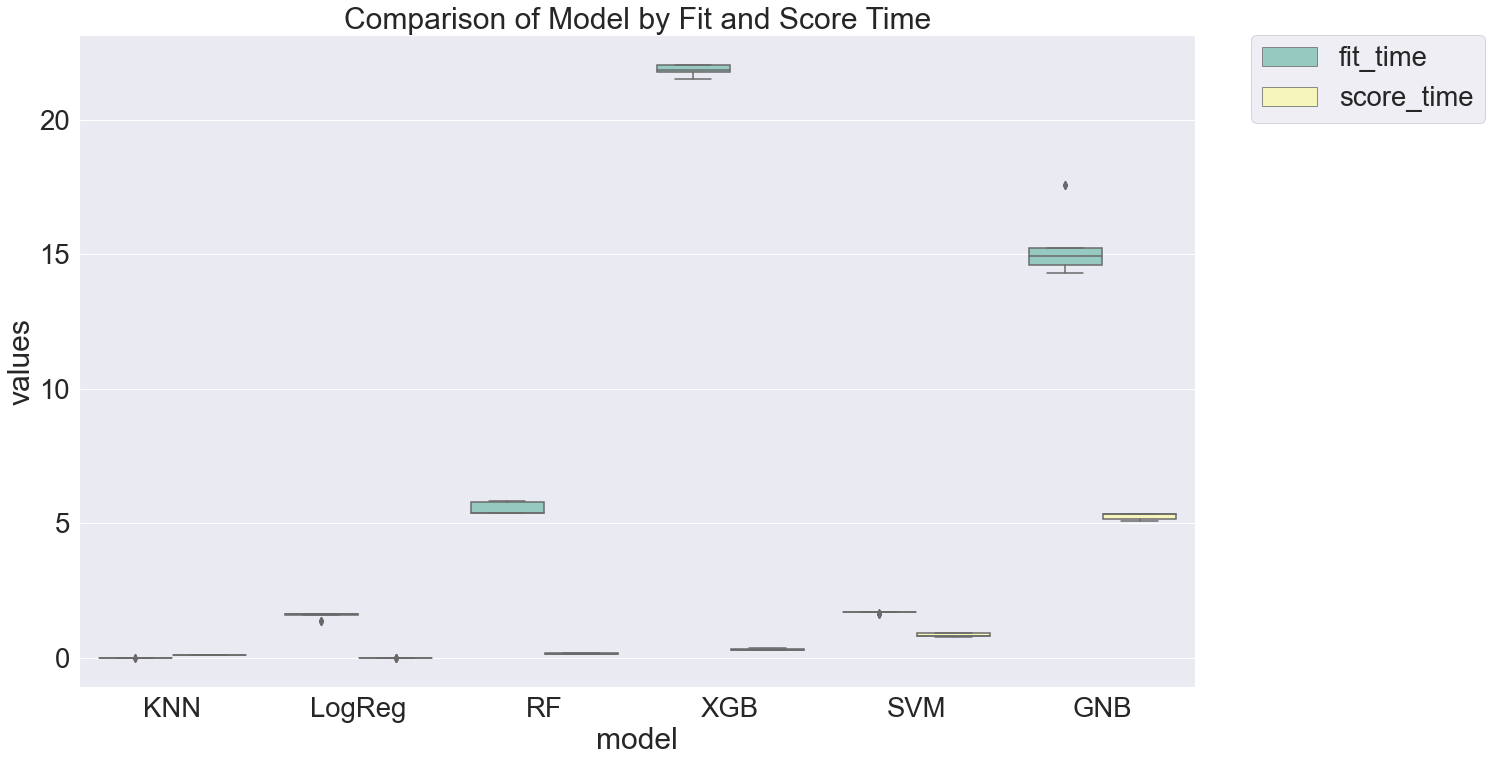

In [29]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [30]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_f1_weighted           test_roc_auc           test_recall_weighted  \
                    std      mean          std      mean                  std   
model                                                                           
GNB            0.007061  0.973520     0.015553  0.929918             0.006711   
KNN            0.020035  0.770753     0.026474  0.867668             0.023396   
LogReg         0.004802  0.985341     0.005088  0.995205             0.004640   
RF             0.005886  0.963122     0.005185  0.991318             0.006002   
SVM            0.007506  0.954368     0.003196  0.992589             0.006644   
XGB            0.005850  0.975876     0.001805  0.995526             0.005756   

                 test_precision_weighted           test_accuracy            
            mean                     std      mean           std      mean  
model                                                                       
GNB     0.974236                0.006654  0.974530      0.006711  0.974236  
KNN     0.739861                0.009074  0.863334      0.023396  0.739861  
LogReg  0.985556                0.004534  0.985622      0.004640  0.985556  
RF      0.963889                0.006294  0.963573      0.006002  0.963889  
SVM     0.957014                0.006142  0.959056      0.006644  0.957014  
XGB     0.976181                0.005841  0.976057      0.005756  0.976181

In [31]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

score_time            fit_time           
              std      mean       std       mean
model                                           
GNB      0.106559  5.253992  1.089480  15.263181
KNN      0.003138  0.105959  0.000496   0.002658
LogReg   0.000333  0.005568  0.100710   1.559988
RF       0.011225  0.145381  0.198068   5.540580
SVM      0.062668  0.840559  0.020778   1.678795
XGB      0.017695  0.310908  0.194554  21.832132